In [3]:
import mlflow
from mlflow import MlflowClient

In [ ]:
class CompareAndDeployModel():
    def __init__(self):
        pass

    def compare_model(self):
        client = MlflowClient()
        

In [12]:
mlflow.set_tracking_uri("https://dagshub.com/Kamal254/Deblur-Image-autoencoder.mlflow")
client = MlflowClient()
for rm in client.search_registered_models():
    print(dict(rm))

{'aliases': {}, 'creation_timestamp': 1727171676303, 'description': '', 'last_updated_timestamp': 1727182266723, 'latest_versions': [<ModelVersion: aliases=[], creation_timestamp=1727182266723, current_stage='None', description='', last_updated_timestamp=1727182266723, name='autoencoder', run_id='c6a51f93c34d46db8a9caca5bd13e700', run_link='', source='mlflow-artifacts:/e7683803a5634ff7b5ef9427f9eba896/c6a51f93c34d46db8a9caca5bd13e700/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='2'>], 'name': 'autoencoder', 'tags': {}}


In [19]:
import mlflow
from mlflow.tracking import MlflowClient
import pandas as pd
import os

os.environ['MLFLOW_TRACKING_USERNAME'] = 'Kamal254'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '3cbdb442b5873e54a9130d1e83862bb2e7993f55'
mlflow.set_tracking_uri("https://dagshub.com/Kamal254/Deblur-Image-autoencoder.mlflow")


client = MlflowClient()

model_name = "autoencoder"

model_versions = client.search_model_versions(f"name='{model_name}'")

model_info = []

for version in model_versions:
    run_id = version.run_id  # Get the run_id for the version
    run = client.get_run(run_id)  # Get the run object
    
    # Check for the required metrics in the run data
    if 'train_accuracy' in run.data.metrics and ' peak signal-to-noise ratio ' in run.data.metrics:
        accuracy = float(run.data.metrics['train_accuracy'])  # Get accuracy
        psnr = float(run.data.metrics[' peak signal-to-noise ratio '])  # Get PSNR

        model_info.append({
            'version': version.version,
            'run_id': run_id,
            'accuracy': accuracy,
            'psnr': psnr,
            'stage': version.current_stage
        })

model_df = pd.DataFrame(model_info)

# Sort by accuracy first and select the top 3
top_3_models = model_df.sort_values(by='accuracy', ascending=False).head(3)

# From the top 3, find the model with the highest PSNR
best_model = top_3_models.sort_values(by='psnr', ascending=False).iloc[0]

print(f"Selected Model Version: {best_model['version']} with PSNR: {best_model['psnr']}")

# Register the selected model as Production
client.transition_model_version_stage(
    name=model_name,
    version=best_model['version'],
    stage="Production"
)
# 6. Tag the model as @Champion
client.set_model_version_tag(
    name=model_name,
    version=best_model['version'],
    key="Aliases",
    value="@Champion"
)

print(f"Model version {best_model['version']} has been moved to Production and tagged as @Champion.")



Selected Model Version: 2 with PSNR: 8.402482986450195


C:\Users\SONU\AppData\Local\Temp\ipykernel_29400\3552330873.py:52: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


Model version 2 has been moved to Production and tagged as @Champion.


Champion Model Version: 2


[2024-09-25 07:35:07,832:INFO:preprocess_IP_OP_data:Image Data Successfully Converted into numpy array]
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


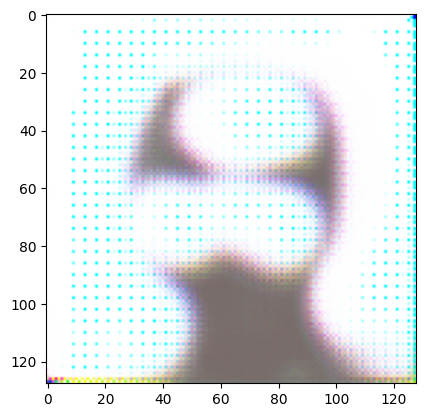

In [2]:
import mlflow
import mlflow.pyfunc
import matplotlib.pyplot as plt
from autoencoder.components.preprocess_IP_OP_data import PrepareDataForTraining
from autoencoder.entity.entity_config import PrepareInputOutputData
import numpy as np
from PIL import Image
import mlflow
from mlflow.tracking import MlflowClient



# Set your MLflow Tracking URI
mlflow.set_tracking_uri("https://dagshub.com/Kamal254/Deblur-Image-autoencoder.mlflow")

# Initialize MLflow client
client = MlflowClient()

# Model name
model_name = "autoencoder"

# 1. Fetch the model version tagged as @Champion
model_versions = client.search_model_versions(f"name='{model_name}'")

# Find the version tagged as @Champion
champion_model_version = None
for version in model_versions:
    # tags = client.get_model_version_tags(name=model_name, version=version.version)
    if version.tags.get("Aliases") == "@Champion":
        champion_model_version = version.version
        break

if champion_model_version:
    print(f"Champion Model Version: {champion_model_version}")
    
    # 2. Load the model
    model_uri = f"models:/{model_name}/{champion_model_version}"
    loaded_model = mlflow.pyfunc.load_model(model_uri)

    # 3. Make predictions using the loaded model
    # Assuming `X_test` is your test data (input features)
    # Load your test data here (e.g., images)
    blur_image_path = "../artifacts/dataset/testingfolder/test_blur_images"
    preprocess_image = PrepareDataForTraining(PrepareInputOutputData)
    array = preprocess_image.image_to_array(blur_image_path)
    # Example of making predictions
    predictions = loaded_model.predict(array)
    output_image = (predictions[0] * 255).astype(np.uint8)  # Scale back to 0-255
    output_image_pil = Image.fromarray(output_image)
    plt.imshow(output_image_pil)
else:
    print("No Champion model found.")
